In [1]:
import requests
import pandas as pd
from itertools import product
from pandasql import sqldf # pip install pandasql

# ------------------------------
# 1. Hente data fra SSB
# ------------------------------
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")


# ------------------------------
# 2. Prosessere og strukturere data
# ------------------------------
def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    
    # Pivot for å få én kolonne per måling
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()

    # Navngi kolonner tydelig
    df_pivot.columns = ["År og ukenr.", 
                        "Fersk laks - Kilospris", 
                        "Fersk laks - Vekt (tonn)", 
                        "Frosset laks - Kilospris", 
                        "Frosset laks - Vekt (tonn)"]

    return df_pivot


# ------------------------------
# 3. Beregne CO₂-utslipp
# ------------------------------
CO2_FACTORS = {
    "Fersk laks": 1.1,    # kg CO₂ per tonn-km (fly)
    "Frosset laks": 0.01  # kg CO₂ per tonn-km (skip)
}

DISTANCES = {
    "Fersk laks": 2000,
    "Frosset laks": 5000
}

def beregn_co2_utslipp(df):
    """Legger til CO₂-utslipp basert på vekt og transporttype."""
    # Smelt datasettet for lettere håndtering
    df_melted = pd.melt(
        df, 
        id_vars=["År og ukenr."], 
        value_vars=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"],
        var_name="Type", 
        value_name="Vekt (tonn)"
    )
    df_melted.dropna(subset=["Vekt (tonn)"], inplace=True)

    # Trekk ut transporttype
    df_melted["Transporttype"] = df_melted["Type"].apply(lambda x: "Fersk laks" if "Fersk" in x else "Frosset laks")

    # Beregn CO₂-utslipp med list comprehension
    df_melted["CO2-utslipp (kg)"] = [
        vekt * CO2_FACTORS[typ] * DISTANCES[typ]
        for vekt, typ in zip(df_melted["Vekt (tonn)"], df_melted["Transporttype"])
    ]
    
    return df_melted


# ------------------------------
# 4. Bruk av Pandas SQL for analyse
# ------------------------------
def total_utslipp_per_uke(df):
    """Oppsummerer CO₂-utslipp per uke med SQL."""
    query = """
        SELECT 
            `År og ukenr.`, 
            Transporttype, 
            SUM(`CO2-utslipp (kg)`) AS `Total CO2-utslipp (kg)`
        FROM df
        GROUP BY `År og ukenr.`, Transporttype
        ORDER BY `År og ukenr.`
    """
    return sqldf(query)


# ------------------------------
# 5. Kjør alt sammen
# ------------------------------
def main():
    try:
        # Hent og prosesser data
        data = fetch_data()
        df_pivot = process_data(data)

        # Rens: fjern rader med NaN i vekt, som er nullverdier
        df_clean = df_pivot.dropna(subset=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"], how='all')

        # Definerer CO₂ utslipp 
        df_with_co2 = beregn_co2_utslipp(df_clean) 

        # defienrer sammenfattet data
        df_summary = total_utslipp_per_uke(df_with_co2)

        return df_summary

    except Exception as e:
        print("Feil:", e)
        return None


df_summary = main()
print(df_summary)

#if __name__ == "__main__":
    #main()
    



     År og ukenr. Transporttype  Total CO2-utslipp (kg)
0         2000U01    Fersk laks               8201600.0
1         2000U01  Frosset laks                 19150.0
2         2000U02    Fersk laks               8918800.0
3         2000U02  Frosset laks                 10800.0
4         2000U03    Fersk laks               8894600.0
...           ...           ...                     ...
2643      2025U18  Frosset laks                 23950.0
2644      2025U19    Fersk laks              39760600.0
2645      2025U19  Frosset laks                 26500.0
2646      2025U20    Fersk laks              42950600.0
2647      2025U20  Frosset laks                 24900.0

[2648 rows x 3 columns]


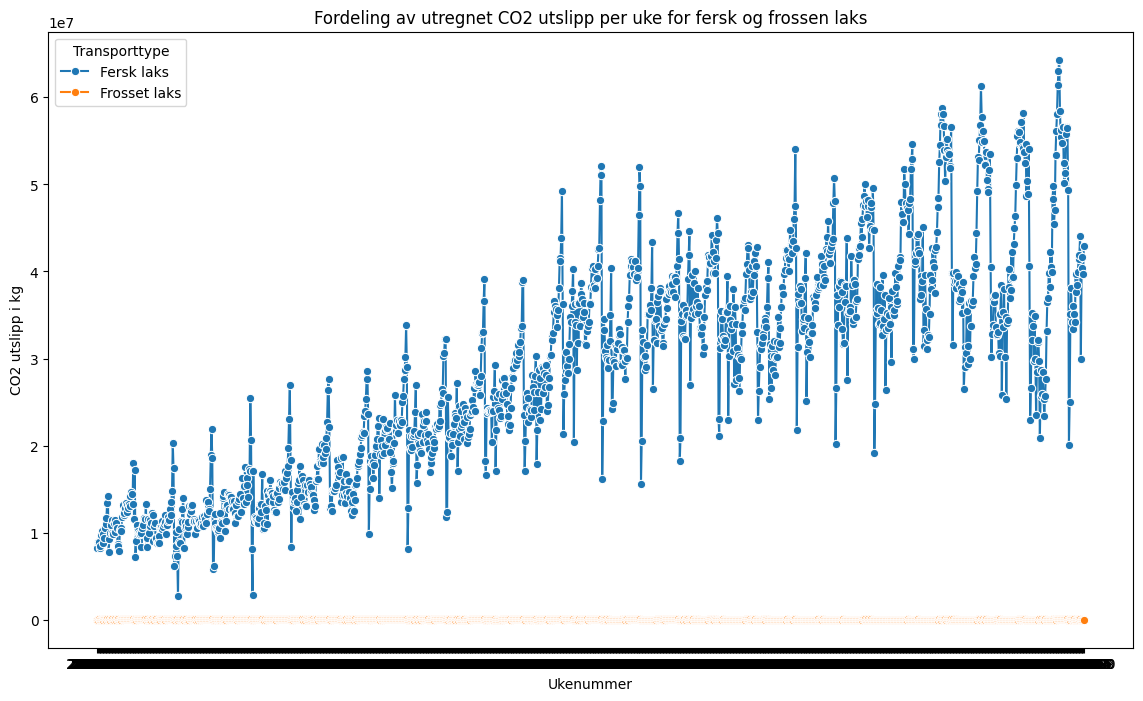

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt

#Denne koden bruker df_summary for å vise co2 utslipp

plt.figure(figsize=(14, 8))
sns.lineplot(data = df_summary , x="År og ukenr.", y="Total CO2-utslipp (kg)", hue="Transporttype", marker="o")

df_summary["År og ukenr."] = range(1, len(df_summary) + 1)
plt.legend(title="Transporttype", loc="upper left", fontsize=10)
plt.title("Fordeling av utregnet CO2 utslipp per uke for fersk og frossen laks")
plt.xlabel("Ukenummer")
plt.ylabel("CO2 utslipp i kg") #det er ikke co2 utslipp for frossen laks fordi vi antar de er konstant og blir fraktet med skip



plt.show()

In [2]:
import requests
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import product

# Hente og prosessere data
api_url = "https://data.ssb.no/api/v0/no/table/03024/"
query = {"query": [], "response": {"format": "json-stat2"}}
response = requests.post(api_url, json=query)
data = response.json()

dim_names = list(data["dimension"].keys())
dim_values = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dim_names]
combinations = list(product(*dim_values))
df = pd.DataFrame(combinations, columns=dim_names)
df["Value"] = data["value"]

df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                           values="Value", aggfunc="sum").reset_index()
df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                    "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]

df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)
df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)
df_pivot["CO2-utslipp (kg)"] = df_pivot["Fersk laks - Vekt (tonn)"] * 1.1 * 2000

# Gruppering per år
vekt_per_year = df_pivot.groupby("År")[["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"]].sum().reset_index()
co2_per_year = df_pivot.groupby("År")["CO2-utslipp (kg)"].sum().reset_index()

# Lage figur
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    subplot_titles=("Årlig eksportert vekt av laks", "Årlig CO₂-utslipp fra fersk laks"),
    vertical_spacing=0.12
)

# Vekt-graf
fig.add_trace(go.Scatter(
    x=vekt_per_year["År"],
    y=vekt_per_year["Fersk laks - Vekt (tonn)"],
    mode="lines+markers",
    name="Fersk laks - Vekt (tonn)",
    line=dict(color="darkblue")
), row=1, col=1)



# CO2-graf
fig.add_trace(go.Scatter(
    x=co2_per_year["År"],
    y=co2_per_year["CO2-utslipp (kg)"],
    mode="lines+markers",
    name="CO₂-utslipp (kg)",
    line=dict(color="blue")
), row=2, col=1)

# Layout
fig.update_layout(
    height=800,
    width=1300,
    title="Interaktiv visualisering: Eksportert vekt og CO₂-utslipp av laks (per år)",
    title_x=0.5,
    showlegend=True
)

fig.update_xaxes(title_text="År", row=1, col=1)
fig.update_yaxes(title_text="Vekt (tonn)", row=1, col=1)

fig.update_xaxes(title_text="År", row=2, col=1)
fig.update_yaxes(title_text="CO₂-utslipp (kg)", row=2, col=1)

fig.show()
